In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-fk2tmjiq
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-fk2tmjiq
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=3ad04dbbd9835198c8539d1c4b35c286525f73679121983516b27db94049cc23
  Stored in directory: /tmp/pip-ephem-wheel-cache-wsq47lai/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from classification_models.keras import Classifiers
from classification_models.tfkeras import Classifiers
from kerastuner.tuners import RandomSearch

<ipython-input-3-e348351603d5>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Classifiers.models_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

In [ ]:
!unzip /content/drive/MyDrive/covers/regression_images.zip -d /content/regression

Streaming output truncated to the last 5000 lines.
  inflating: /content/regression/1_3526.jpg  
  inflating: /content/regression/2_3527.jpg  
  inflating: /content/regression/3_3528.jpg  
  inflating: /content/regression/7_3529.jpg  
  inflating: /content/regression/3_3530.jpg  
  inflating: /content/regression/5_3531.jpg  
  inflating: /content/regression/2_3532.jpg  
  inflating: /content/regression/2_3533.jpg  
  inflating: /content/regression/32_3534.jpg  
  inflating: /content/regression/14_3535.jpg  
  inflating: /content/regression/3_3536.jpg  
  inflating: /content/regression/2_3537.jpg  
  inflating: /content/regression/4_3538.jpg  
  inflating: /content/regression/6_3539.jpg  
  inflating: /content/regression/5_3540.jpg  
  inflating: /content/regression/4_3541.jpg  
  inflating: /content/regression/3_3542.jpg  
  inflating: /content/regression/1_3543.jpg  
  inflating: /content/regression/2_3544.jpg  
  inflating: /content/regression/2_3545.jpg  
  inflating: /content/regre

# Pre-process images

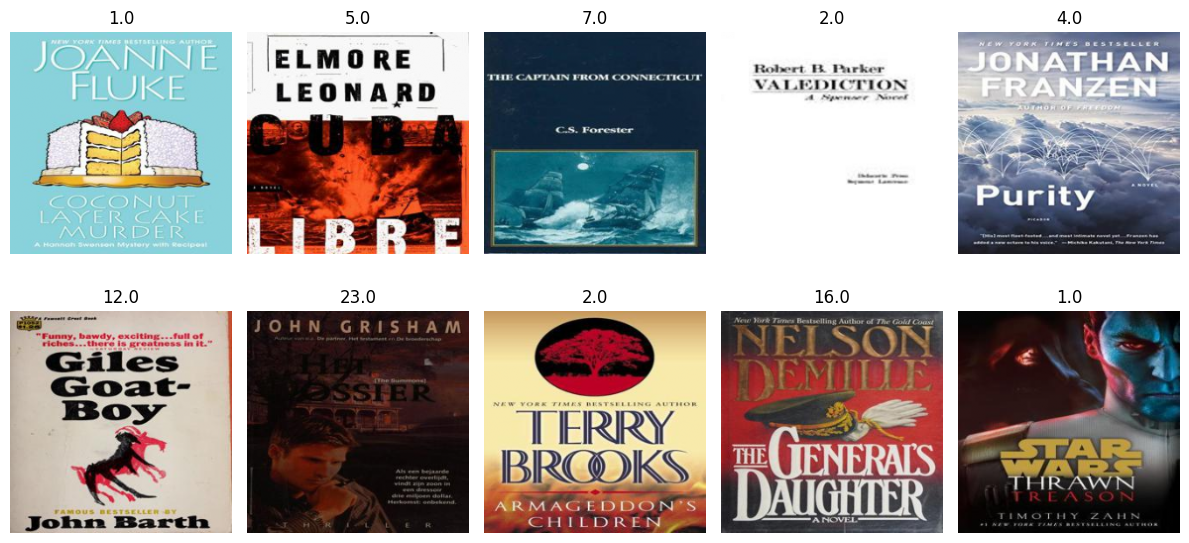

In [ ]:
image_dir = '/content/regression'
image_size = (224, 224)
batch_size = 32

def image_generator(image_dir, batch_size, image_size):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            filepath = os.path.join(image_dir, filename)
            label = float(filename.split('_')[0])  # Extract the label from the filename and convert to float

            # Load and preprocess the image
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, image_size)  # Resize the image
            image = image / 255.0  # Normalize pixel values to the range of 0-1

            images.append(image)
            labels.append(label)

            if len(images) == batch_size:
                yield np.array(images), np.array(labels)
                images = []
                labels = []

    if images:  # Yield the remaining images if the total count is not a multiple of batch_size
        yield np.array(images), np.array(labels)

# Generate the data using the image generator
data_generator = image_generator(image_dir, batch_size, image_size)
X, y = zip(*data_generator)

# Convert the generator output to arrays
X = np.concatenate(X)
y = np.concatenate(y)

# Split the dataset into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt

# Define a function to display images and labels
def display_images(images, labels):
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    axs = axs.ravel()

    for i in range(10):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display some images and labels from the training set
display_images(X_train[:10], y_train[:10])

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Val set size:", len(X_val))

import numpy as np

# Print the statistics of the target variable
print("Target variable statistics:")
print("Min:", np.min(y_train))
print("Max:", np.max(y_train))
print("Mean:", np.mean(y_train))
print("Standard Deviation:", np.std(y_train))


# Models

## VGG19

### Train Model

In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Display loss during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_2_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'VGG19_weights.h5'))


80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/100
171/171 [==============================] - 19s 48ms/step - loss: 166.2096 - val_loss: 141.9368
Epoch 2/100
171/171 [==============================] - 6s 33ms/step - loss: 160.3493 - val_loss: 142.9803
Epoch 3/100
171/171 [==============================] - 6s 33ms/step - loss: 159.9412 - val_loss: 140.0981
Epoch 4/100
171/171 [==============================] - 6s 33ms/step - loss: 158.6594 - val_loss: 139.4428
Epoch 5/100
171/171 [==============================] - 6s 33ms/step - loss: 158.7728 - val_loss: 138.5482
Epoch 6/100
171/171 [==============================] - 6s 33ms/step - loss: 157.6241 - val_loss: 138.5014
Epoch 7/100
171/171 [==============================] - 6s 33ms/step - loss: 157.3702 - val_loss: 138.4930
Epoch 8/100
171/171 [==============================] - 6s 33ms/step - loss: 156.5088 - val_loss: 137.7788
Epoch 9/100
171/171 [==============================] - 6s 33ms/step - loss: 155.7304 -

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score on the test set
test_r2_score = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared Score:", test_r2_score)

54/54 [==============================] - 1s 25ms/step
Test MSE: 201.13464823865723
Test MAE: 7.970414019553351
Test R-squared Score: 0.018771337412300748


### Hyperparameter tuning

In [ ]:
# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define the hyperparameter search space
def build_model(hp):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu')(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/covers/tuner',
    project_name='VGG19_tuning')

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Display loss during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_2_weights'
os.makedirs(save_dir, exist_ok=True)
best_model.save_weights(os.path.join(save_dir, 'hyper_VGG19_weights.h5'))


Trial 5 Complete [00h 05m 41s]
val_loss: 126.95276641845703

Best val_loss So Far: 125.80660247802734
Total elapsed time: 00h 31m 01s
Epoch 1/100
171/171 [==============================] - 8s 40ms/step - loss: 117.1449 - val_loss: 129.8772
Epoch 2/100
171/171 [==============================] - 6s 34ms/step - loss: 114.8407 - val_loss: 130.5121
Epoch 3/100
171/171 [==============================] - 6s 34ms/step - loss: 112.9205 - val_loss: 128.5118
Epoch 4/100
171/171 [==============================] - 6s 34ms/step - loss: 113.1602 - val_loss: 128.5103
Epoch 5/100
171/171 [==============================] - 6s 34ms/step - loss: 112.0847 - val_loss: 132.2106
Epoch 6/100
171/171 [==============================] - 6s 34ms/step - loss: 110.2077 - val_loss: 127.3263
Epoch 7/100
171/171 [==============================] - 6s 34ms/step - loss: 110.0036 - val_loss: 125.7928
Epoch 8/100
171/171 [==============================] - 6s 34ms/step - loss: 108.0408 - val_loss: 129.3428
Epoch 9/100
171/17

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score on the test set
test_r2_score = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared Score:", test_r2_score)

54/54 [==============================] - 2s 32ms/step
Test MSE: 287.26461290334544
Test MAE: 9.2726989624037
Test R-squared Score: -0.4273110168244807


### Fine Tuning

In [ ]:
import os
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Lower the learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Continue training with fine-tuning
fine_tune_epochs = 50
history_fine = model.fit(X_train, y_train, epochs=history.epoch[-1] + fine_tune_epochs, batch_size=32,
                         validation_data=(X_val, y_val), initial_epoch=history.epoch[-1], callbacks=[early_stopping])

# Extract loss from the training history
train_loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Display loss during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_2_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'VGG19_weights_fine_tuned.h5'))


Epoch 1/100
171/171 [==============================] - 8s 42ms/step - loss: 165.5988 - val_loss: 141.4553
Epoch 2/100
171/171 [==============================] - 6s 34ms/step - loss: 160.9403 - val_loss: 141.4358
Epoch 3/100
171/171 [==============================] - 6s 34ms/step - loss: 159.7745 - val_loss: 142.8128
Epoch 4/100
171/171 [==============================] - 6s 34ms/step - loss: 159.0118 - val_loss: 139.5145
Epoch 5/100
171/171 [==============================] - 6s 34ms/step - loss: 158.0522 - val_loss: 138.4279
Epoch 6/100
171/171 [==============================] - 6s 34ms/step - loss: 157.9556 - val_loss: 139.2811
Epoch 7/100
171/171 [==============================] - 6s 34ms/step - loss: 156.9986 - val_loss: 137.9171
Epoch 8/100
171/171 [==============================] - 6s 34ms/step - loss: 156.6848 - val_loss: 139.1179
Epoch 9/100
171/171 [==============================] - 6s 34ms/step - loss: 156.1628 - val_loss: 141.5518
Epoch 10/100
171/171 [========================

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score on the test set
test_r2_score = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared Score:", test_r2_score)

54/54 [==============================] - 1s 25ms/step
Test MSE: 206.13358112971795
Test MAE: 7.366386757414583
Test R-squared Score: -0.024201095673844986


## ResNet34

In [ ]:
ResNet34, preprocess_input = Classifiers.get('resnet34')

# Load the pre-trained model
base_model = ResNet34(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Extract loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Display loss during training
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f}")
    print()

# Save the model weights
save_dir = '/content/drive/MyDrive/covers/model_2_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'ResNet34_weights.h5'))

85521592/85521592 [==============================] - 2s 0us/step
Epoch 1/100
171/171 [==============================] - 9s 32ms/step - loss: 164.5399 - val_loss: 142.7729
Epoch 2/100
171/171 [==============================] - 3s 18ms/step - loss: 162.6528 - val_loss: 142.3717
Epoch 3/100
171/171 [==============================] - 3s 19ms/step - loss: 162.1350 - val_loss: 142.4063
Epoch 4/100
171/171 [==============================] - 3s 18ms/step - loss: 161.6966 - val_loss: 143.8500
Epoch 5/100
171/171 [==============================] - 3s 19ms/step - loss: 162.0897 - val_loss: 143.6385
Epoch 6/100
171/171 [==============================] - 3s 19ms/step - loss: 161.9539 - val_loss: 142.1301
Epoch 7/100
171/171 [==============================] - 3s 19ms/step - loss: 161.9162 - val_loss: 142.0756
Epoch 8/100
171/171 [==============================] - 3s 19ms/step - loss: 162.1515 - val_loss: 142.7032
Epoch 9/100
171/171 [==============================] - 3s 19ms/step - loss: 161.8119 - 

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score on the test set
test_r2_score = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared Score:", test_r2_score)

54/54 [==============================] - 2s 17ms/step
Test MSE: 199.56172270764523
Test MAE: 7.783290077625377
Test R-squared Score: 0.008452024500031796


## Regression model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build the regression model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)


Epoch 1/100
171/171 [==============================] - 6s 23ms/step - loss: 180.9444 - val_loss: 145.1468
Epoch 2/100
171/171 [==============================] - 3s 15ms/step - loss: 172.1533 - val_loss: 143.1421
Epoch 3/100
171/171 [==============================] - 3s 15ms/step - loss: 170.2451 - val_loss: 143.5341
Epoch 4/100
171/171 [==============================] - 3s 15ms/step - loss: 168.1994 - val_loss: 142.3196
Epoch 5/100
171/171 [==============================] - 3s 15ms/step - loss: 164.6612 - val_loss: 148.4758
Epoch 6/100
171/171 [==============================] - 3s 15ms/step - loss: 157.1753 - val_loss: 150.1933
Epoch 7/100
171/171 [==============================] - 3s 15ms/step - loss: 144.3254 - val_loss: 150.3530
Epoch 8/100
171/171 [==============================] - 3s 15ms/step - loss: 120.6700 - val_loss: 155.1721
Epoch 9/100
171/171 [==============================] - 3s 15ms/step - loss: 98.9137 - val_loss: 156.6498
Epoch 10/100
171/171 [=========================

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score on the test set
test_r2_score = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared Score:", test_r2_score)

54/54 [==============================] - 0s 7ms/step
Test MSE: 187.86217307948948
Test MAE: 7.552790077243782
Test R-squared Score: -0.07797498501452615
